引入需要的库

In [1]:
from __future__ import absolute_import

import cv2
import numpy as np
import os
import os.path as osp
import pdb
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

将此ipynb与Google Drive连接，从而使用云端硬盘上的数据库，在复现时可忽略

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


将此ipynb文件与Drive中的文件夹建立联系，从而使用此文件夹中的数据，在复现时可忽略

In [3]:
!ls "/content/drive/My Drive/"
path = "/content/drive/My Drive/cell_seg"
os.chdir(path)
os.listdir(path)

 cell_seg  'Colab Notebooks'


['dataset1',
 'dataset2',
 'dataset2.h5',
 'unet_dataset2.hdf5',
 'unet_dataset1.hdf5',
 'dataset1.h5',
 'dataset1.ipynb',
 'dataset1_focal.h5',
 'unet_dataset1_focal.hdf5']

原始demo

In [4]:
def unit16b2uint8(img):
    if img.dtype == 'uint8':
        return img
    elif img.dtype == 'uint16':
        return img.astype(np.uint8)
    else:
        #raise TypeError('No such of img transfer type: {} for img'.format(img.dtype))
        return img.astype(np.uint8)

def img_standardization(img):
    img = unit16b2uint8(img)
    if len(img.shape) == 2:
        img = np.expand_dims(img, 2)
        img = np.tile(img, (1, 1, 3))
        return img
    elif len(img.shape) == 3:
        return img
    else:
        raise TypeError('The Depth of image large than 3 \n')

训练模型搭建

In [5]:
#损失函数，用于前景与背景不均衡时的情况
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(K.epsilon()+pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed


def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#模型
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = keras.Input(shape = input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-5,beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss=[focal_loss(alpha=.25, gamma=2)], metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), dice_coef])
    
    model.summary()


    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [6]:
model = unet()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

训练集和测试集数据的预处理

In [7]:
#在二分类时，将细胞图像与标签归一化，并将标签二值化
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
 
        for i in range(num_class):
            new_mask[mask == i,i] = 1 #将平面的mask的每类，都单独变成一层，
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = unit16b2uint8(img)
        mask = unit16b2uint8(mask)
        img = img / 255
        mask = mask / 255
        mask[mask > 0] = 1
        mask[mask <= 0] = 0
    return (img,mask)

#训练数据生成器
def train_Generator(batch_size,train_path, mask_path, image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False, num_class = 2,save_to_dir = None, target_size = (256, 256),seed = 1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)
   
#测试数据生成器
def testGenerator(test_path,target_size = (256,256),flag_multi_class = False, n = 33):
    files = sorted([osp.join(test_path, image) for image in os.listdir(test_path) if image.find('.tif') != -1])
    for i in range(n):
        img = cv2.imread(os.path.join(test_path,'t{:0>3d}.tif'.format(i)),-1)
        img = img / 255
        img = cv2.resize(img,target_size)
        img = np.reshape(img,img.shape + (1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,) + img.shape)
        yield img


训练

In [10]:
res_path = './dataset1/test_RES'
if not osp.exists(res_path):
    os.mkdir(res_path)
    
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='nearest')
myGene = train_Generator(2,'./dataset1','./dataset1/train_GT','train','SEG',data_gen_args)
model_checkpoint = ModelCheckpoint('unet_dataset1_focal.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=600,epochs=10,callbacks=[model_checkpoint])
model.save('dataset1_focal.h5')

Found 175 images belonging to 1 classes.
Found 175 images belonging to 1 classes.
Epoch 1/10
600/600 [==============================] - ETA: 0s - loss: 918.9479 - accuracy: 0.9710 - mean_io_u: 0.4439 - dice_coef: 0.5894
Epoch 00001: loss improved from inf to 918.94788, saving model to unet_dataset1_focal.hdf5
600/600 [==============================] - 65s 108ms/step - loss: 918.9479 - accuracy: 0.9710 - mean_io_u: 0.4439 - dice_coef: 0.5894
Epoch 2/10
600/600 [==============================] - ETA: 0s - loss: 846.6191 - accuracy: 0.9716 - mean_io_u: 0.4444 - dice_coef: 0.6174
Epoch 00002: loss improved from 918.94788 to 846.61914, saving model to unet_dataset1_focal.hdf5
600/600 [==============================] - 65s 108ms/step - loss: 846.6191 - accuracy: 0.9716 - mean_io_u: 0.4444 - dice_coef: 0.6174
Epoch 3/10
600/600 [==============================] - ETA: 0s - loss: 818.6248 - accuracy: 0.9722 - mean_io_u: 0.4440 - dice_coef: 0.6296
Epoch 00003: loss improved from 846.61914 to 818

预测

In [9]:
testGene = testGenerator(r"./dataset1/test")
results = model.predict_generator(testGene,33,verbose=1)


Instructions for updating:
Please use Model.predict, which supports generators.
33/33 [==============================] - 22s 652ms/step


深度优先搜索

In [10]:
import sys

sys.setrecursionlimit(10000)

def IndexInRange(i, bond = 628):
    return (i < bond) and (i >= 0)

def DFS(result, i, j, color):
    result[i, j] = color
    if (IndexInRange(i - 1) and result[i - 1, j] == 255):
        DFS(result, i - 1, j, color)
    if (IndexInRange(i + 1) and result[i + 1, j] == 255):
        DFS(result, i + 1, j, color)
    if (IndexInRange(j - 1) and result[i, j - 1] == 255):
        DFS(result, i, j - 1, color)
    if (IndexInRange(j + 1) and result[i, j + 1] == 255):
        DFS(result, i, j + 1, color)
    return

后处理得结果

In [ ]:
for k in range(33):
    color_used = [False for i in range(256)]
    color_used = np.array(color_used)
    color_used[0] = True
    color_used[255] = True
    result = results[k]
    result = cv2.resize(result, (628,628))
    result[result > 0.55] = 1
    result[result <= 0.55] = 0
    result = result * 255
    result = unit16b2uint8(result)
    for i in range(628):
        for j in range(628):
            if result[i, j] == 255:
                color = np.random.randint(low=1, high=254, size=1)
                while(color_used[int(color)] == True):
                  color = np.random.randint(low=1, high=254, size=1)
                color_used[color] = True
                DFS(result, i, j, color)
    cv2.imwrite(osp.join(res_path, 'mask{:0>3d}.tif'.format(k)), result.astype(np.uint16))

如果上面的循环执行不了，可能要手动循环执行以下两段代码，代替上式的循环。

<function matplotlib.pyplot.show>

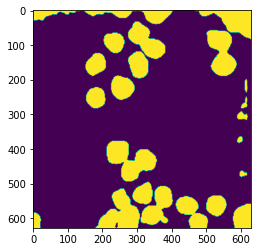

In [18]:

k = 0
result = results[k]
result = cv2.resize(result, (628,628))
result[result > 0.5] = 1
result[result <= 0.5] = 0
result = result * 255
result = unit16b2uint8(result)

plt.imshow(result)
plt.show

True

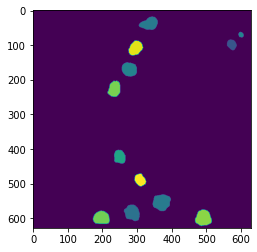

In [ ]:
color_used = [False for i in range(256)]
color_used = np.array(color_used)
color_used[0] = True
color_used[255] = True
color = np.random.randint(low=1, high=254, size=1)
for i in range(628):
    for j in range(628):
        if result[i, j] == 255:
            #color = np.random.randint(low=1, high=254, size=1)
            while(color_used[int(color)] == True):
              color = np.random.randint(low=1, high=254, size=1)
            color_used[color] = True
            DFS(result, i, j, color)
            
plt.imshow(result)
plt.show
cv2.imwrite(osp.join(res_path, 'mask{:0>3d}.tif'.format(k)), result.astype(np.uint16))